In [13]:
import torch
from torch.autograd import Variable
from torchvision import models
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dataset
import argparse
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
matplotlib inline

## ModifiedVGG16 

Since a modified version of VGG16 was used while pruning, we need the same during test and visualization

In [7]:
class ModifiedVGG16Model(torch.nn.Module):
    def __init__(self):
        super(ModifiedVGG16Model, self).__init__()

        model = models.vgg16(pretrained=True)
        self.features = model.features

        for param in self.features.parameters():
            param.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(25088, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2))

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Task

This notebook was aimed to experiment with extracting feature maps and weights and visualisation rather than comapring accuracy of a pruned VGG16 network.

Hence for the above state purpose, the model was trained and tested on a very small dataset with minimum training iterations after pruning.

In [8]:
class vis_cnn:
    def __init__(self, train_path, test_path, model):
        self.train_data_loader = dataset.loader(train_path)
        self.test_data_loader = dataset.test_loader(test_path)
        self.img = None
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        
    def test(self):
        self.model.eval()
        correct = 0
        total = 0

        for i, (batch, label) in enumerate(self.test_data_loader):
            batch = batch
            output = model(Variable(batch))
            pred = output.data.max(1)[1]
            correct += pred.cpu().eq(label).sum()
            total += label.size(0)

        print("Accuracy :", float(correct) / total)
        
    def imshow(self,inp, title=None):
        """Imshow for Tensor."""
        inp = inp.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        plt.imshow(inp)
        
    def plot_features(self,features):
        features = np.reshape(features,(features.shape[1],features.shape[2],features.shape[3]))
        n_features = features.shape[0]
        n_cols = 10
        n_rows = (n_features// n_cols) + 1
        fig = plt.figure(figsize=(n_cols,n_rows))
        for i in range(features.shape[0]):
            ax1 = fig.add_subplot(n_rows,n_cols,i+1)
            feature = features[i,:,:]
            ax1.imshow(feature)
            f = plt.imshow(feature)
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
        
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()
        
        
    def prepare_test_image(self):
        #Get the first image of the test set.
        for i, (batch, label) in enumerate(self.test_data_loader):
            self.img = batch[0]
            self.imshow(self.img)
            self.img = self.img.unsqueeze(0)
            print(self.img.size())
            break
            
    def display_layers(self):
        for param_tensor in self.model.state_dict():
            print(param_tensor,"\t",model.state_dict()[param_tensor].size())
            
    def plot_weight(self,weight,one_set=False):
        print(weight.shape)
        weight = np.clip(weight, 0, 1)
        if one_set:
            #display just the first kernel weight for clearer picture.
            weight = weight[0]
            print(weight.shape)
            plt.figure(figsize=(20,20))
            plt.imshow(weight)
            x1,x2,y1,y2 = plt.axis()
            return
            
            
        n_kernel = weight.shape[0]
        n_cols = 10
        n_rows = (n_kernel// n_cols) + 1
        fig = plt.figure(figsize=(n_cols,n_rows))
        for i in range(weight.shape[0]):
            ax1 = fig.add_subplot(n_rows,n_cols,i+1)
            ax1.imshow(weight[i])
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
            
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        #plt.show()
        return plt
        
    def display_layer_weights(self,index = 0,one_set=False):
        # weight-1
        weight = self.layer_weights[index]
        self.plot_weight(weight,one_set)
        
    def display_feature_map(self,index = 0):
        self.plot_features(self.feature_maps[index])
        
    def prepare_feature_map(self):
        self.feature_maps = []
        out = self.img
        for conv in self.conv_layers:
            out = conv(out)
            self.feature_maps.append(out.detach().numpy())

    def prepare_layers(self):
        #Get the weights for the first 5 layers
        #we will get the first 5 conv layers.
        count = 0
        layer_index = 0
        self.conv_layers = []
        while count < 5:
            res = list(model.features._modules.items())[layer_index]
            if isinstance(res[1], torch.nn.modules.conv.Conv2d):
                self.conv_layers.append(res[1])
                count += 1
                
            layer_index += 1
        
        print(self.conv_layers)
        
        #weight matrices for conv layers:
        self.layer_weights = []
        for conv in self.conv_layers:
            weight = conv.weight.data.cpu().numpy()
            self.layer_weights.append(weight)
            
        print(len(self.layer_weights))

To keep things simple the model was trained and tested using the same small dataset present in folder `test/`.

### Accuracy before pruning

!['not-found'](images/before.png)

In [14]:
model = torch.load("model_prunned")
visualise = vis_cnn('test','test',model)
visualise.test()

Accuracy : 0.7428571428571429


Training the model on a larger dataset and then pruning it would result in a much better accuracy.As seen in the above cell, the pruned network still actually has about 20% better accuracy.

## Test Image

Since the images have already been stored in the `test_data_loader`, we use the first image for it.  

torch.Size([1, 3, 224, 224])


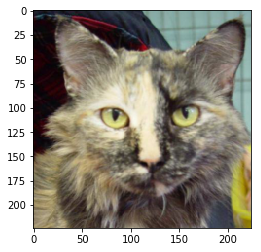

In [10]:
visualise.prepare_test_image()

In [328]:
visualise.display_layers()

classifier.1.weight 	 torch.Size([4096, 20433])
classifier.1.bias 	 torch.Size([4096])
classifier.4.weight 	 torch.Size([4096, 4096])
classifier.4.bias 	 torch.Size([4096])
classifier.6.weight 	 torch.Size([2, 4096])
classifier.6.bias 	 torch.Size([2])
features.0.weight 	 torch.Size([63, 3, 3, 3])
features.0.bias 	 torch.Size([63])
features.2.weight 	 torch.Size([63, 63, 3, 3])
features.2.bias 	 torch.Size([63])
features.5.weight 	 torch.Size([123, 63, 3, 3])
features.5.bias 	 torch.Size([123])
features.7.weight 	 torch.Size([125, 123, 3, 3])
features.7.bias 	 torch.Size([125])
features.10.weight 	 torch.Size([233, 125, 3, 3])
features.10.bias 	 torch.Size([233])
features.12.weight 	 torch.Size([222, 233, 3, 3])
features.12.bias 	 torch.Size([222])
features.14.weight 	 torch.Size([245, 222, 3, 3])
features.14.bias 	 torch.Size([245])
features.17.weight 	 torch.Size([450, 245, 3, 3])
features.17.bias 	 torch.Size([450])
features.19.weight 	 torch.Size([452, 450, 3, 3])
features.19.bias 

## Layers 1-5

In [329]:
visualise.prepare_layers()
visualise.prepare_feature_map()

[Conv2d(3, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(63, 63, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(63, 123, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(123, 125, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(125, 233, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]
5


# Visualizing

## Feature maps and weights related to the first 5 layers

## Layer 1

### Feature map from conv-layer 1

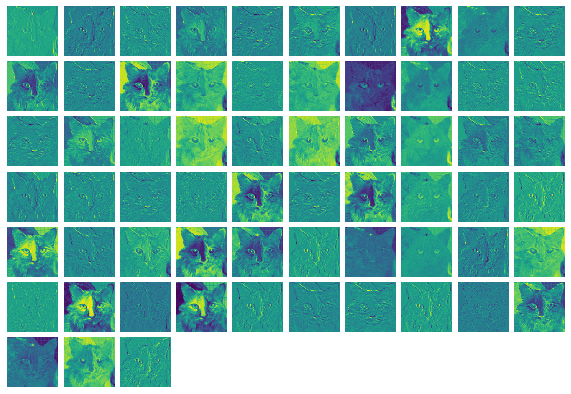

In [303]:
visualise.display_feature_map(0)

### Weights for layer-1

(63, 3, 3, 3)


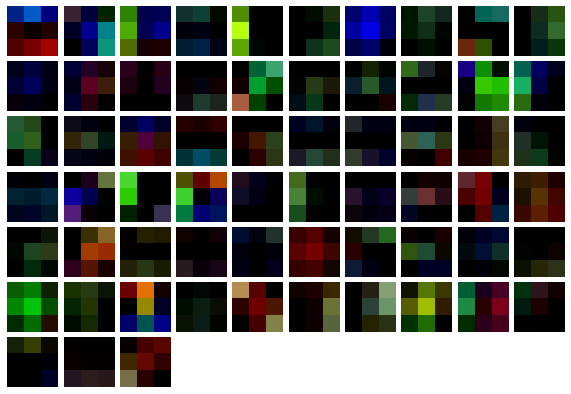

In [304]:
visualise.display_layer_weights(0)

## Layer 2

### Feature map from conv-layer 2

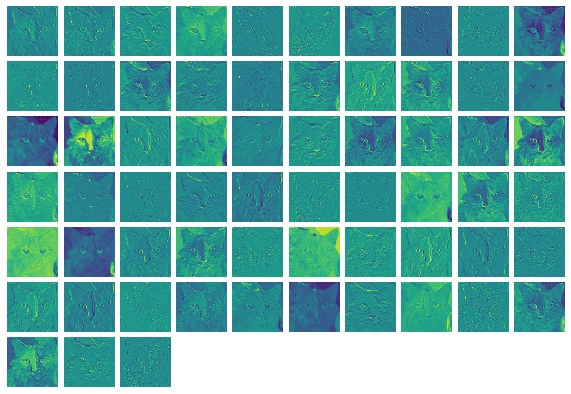

In [273]:
visualise.display_feature_map(1)

(63, 63, 3, 3)


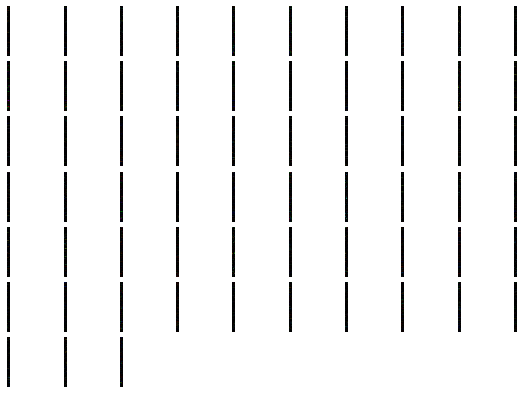

In [334]:
visualise.display_layer_weights(1)# display all 63 of the weight matrices

Since dimention of the weight matrix is 63x3x3, below we check out the first of the 63 kernel's

(63, 63, 3, 3)
(63, 3, 3)


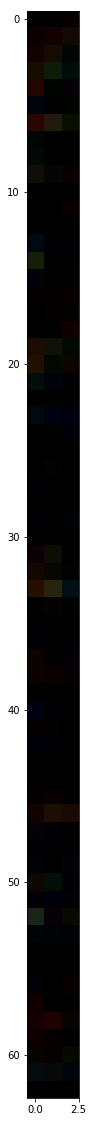

In [330]:
visualise.display_layer_weights(1,one_set=True)#display just the first one.

## Layer 3

### Feature map from conv-layer 3

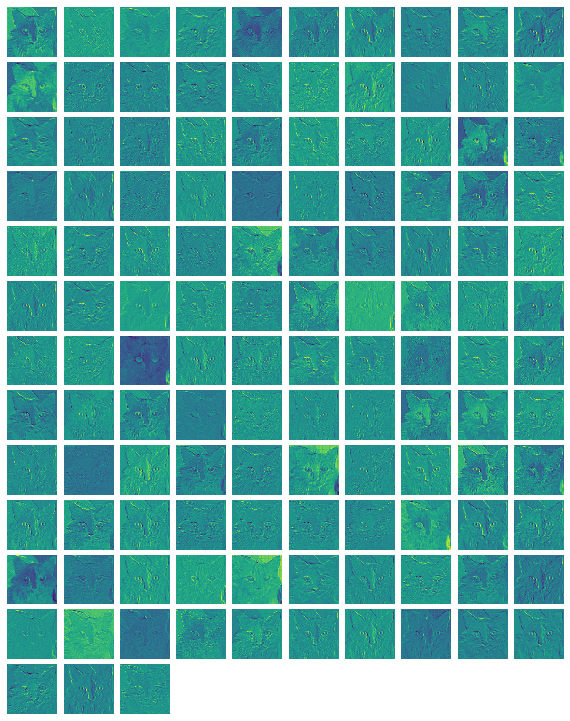

In [285]:
visualise.display_feature_map(2)

### Weights layer-3

(123, 63, 3, 3)
(63, 3, 3)


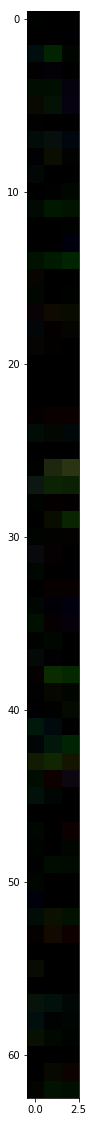

In [331]:
visualise.display_layer_weights(2,one_set=True)

## Layer 4

### Feature map from conv-layer 4

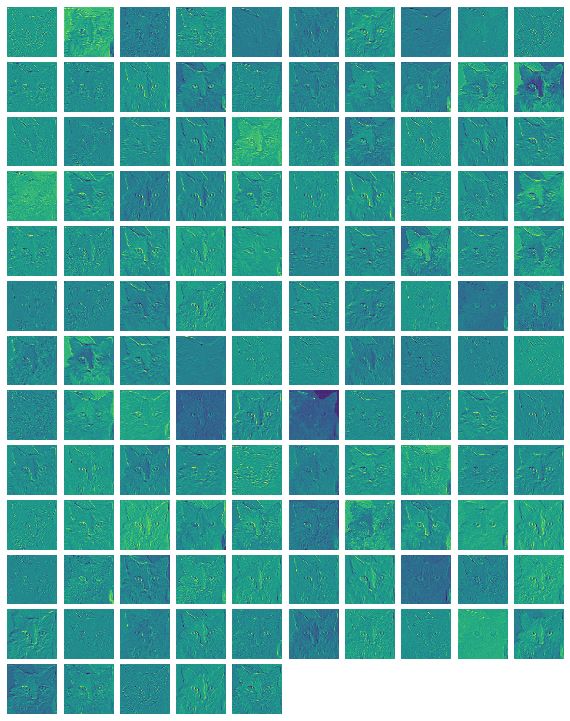

In [335]:
visualise.display_feature_map(3)

### Weights layer-4

(125, 123, 3, 3)
(123, 3, 3)


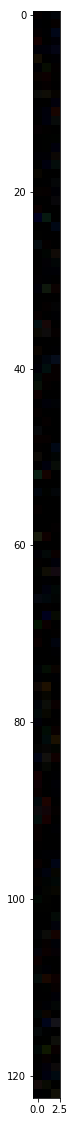

In [332]:
visualise.display_layer_weights(3,one_set=True)

#### Closer look at weights from layer 4

!['not found'](images/layer-4.png)

## Layer 5

### Feature map from conv-layer 5

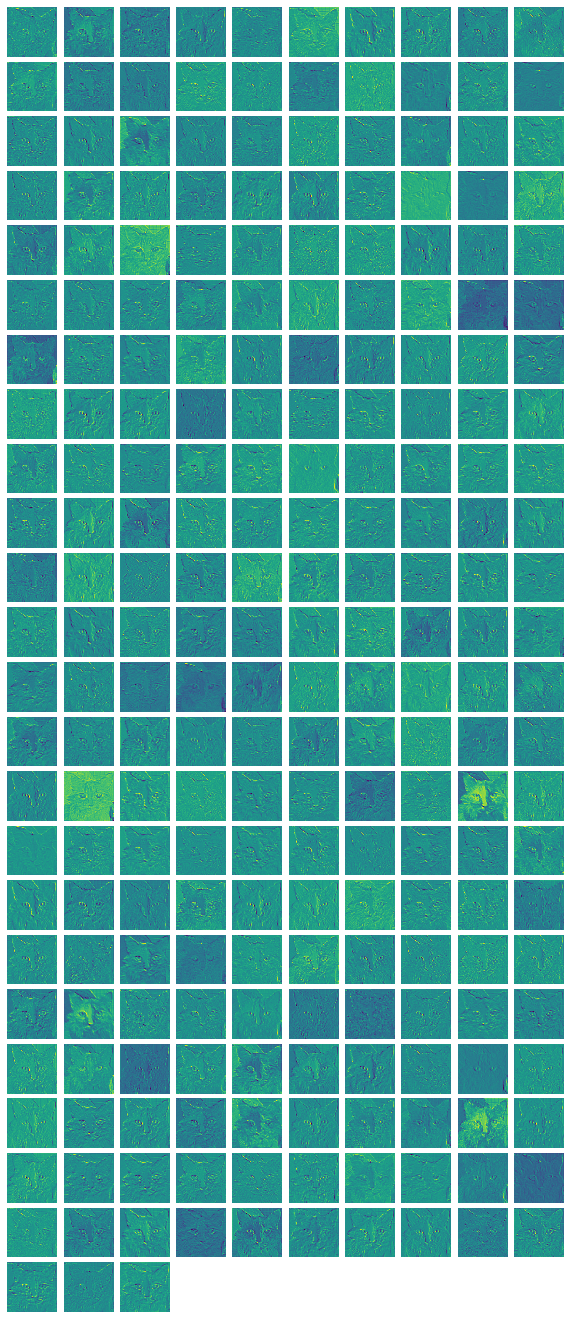

In [276]:
visualise.display_feature_map(4)

### Weights layer-5

(233, 125, 3, 3)
(125, 3, 3)


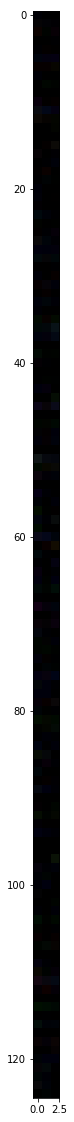

In [333]:
visualise.display_layer_weights(4,one_set=True)